In [1]:
%load_ext autoreload
%autoreload 2

# Part 1. Logic gates

1. This
2. That
3. More
4. Steps

In [69]:
import numpy as np
import perceptron
import json

dataset = json.load(open("./test_data.json", "r"))

## 1.1 Plotting AND, OR, NAND, NOR gates with their decision function

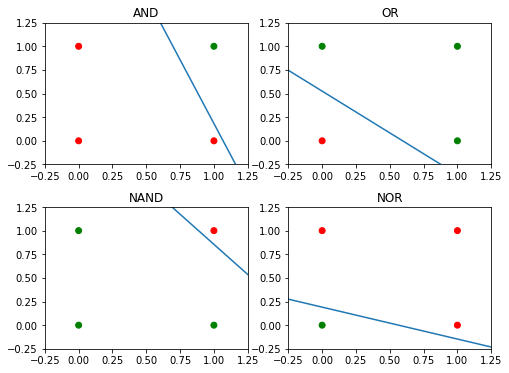

In [85]:
# Learning the decision boundary

import matplotlib.pyplot as plt


def get_colors(y):
    colors = [None, 'green', 'red']  # class 1: green, class -1: red
    return [colors[c] for c in y]


plt.figure(figsize=(8, 6))
X = np.array(dataset["and"]["X"])  # X is the same for all boolean logic cases

# CASE AND
y = dataset["and"]["y"]
and_coefs, and_cls_errors = perceptron.fit(
    perceptron.insert_intercept(X), 
    np.array(y), 
    max_epochs=15)

xx = np.linspace(-0.5, 1.5, 10)
yy = perceptron.decision_function2d(xx, and_coefs)

plt.subplot(221)
plt.xlim(-0.25, 1.25)
plt.ylim(-0.25, 1.25)
plt.scatter(X[:,0], X[:,1], c=get_colors(y))
plt.plot(xx, yy)  # decision boundary
plt.title("AND")

# CASE OR
y = dataset["or"]["y"]
or_coefs, or_cls_errors = perceptron.fit(
    perceptron.insert_intercept(X), 
    np.array(y), 
    max_epochs=15)

xx = np.linspace(-0.5, 1.5, 10)
yy = perceptron.decision_function2d(xx, or_coefs)

plt.subplot(222)
plt.xlim(-0.25, 1.25)
plt.ylim(-0.25, 1.25)
plt.scatter(X[:,0], X[:,1], c=get_colors(y))
plt.plot(xx, yy)  # decision boundary
plt.title("OR")

# CASE NAND
y = dataset["nand"]["y"]
nand_coefs, nand_cls_errors = perceptron.fit(
    perceptron.insert_intercept(X), 
    np.array(y), 
    max_epochs=15)

xx = np.linspace(-0.5, 1.5, 10)
yy = perceptron.decision_function2d(xx, nand_coefs)

plt.subplot(223)
plt.xlim(-0.25, 1.25)
plt.ylim(-0.25, 1.25)
plt.scatter(X[:,0], X[:,1], c=get_colors(y))
plt.plot(xx, yy)  # decision boundary
plt.title("NAND")

# CASE NOR
y = dataset["nor"]["y"]
nor_coefs, nor_cls_errors = perceptron.fit(
    perceptron.insert_intercept(X), 
    np.array(y), 
    max_epochs=15)

xx = np.linspace(-0.5, 1.5, 10)
yy = perceptron.decision_function2d(xx, nor_coefs)

plt.subplot(224)
plt.xlim(-0.25, 1.25)
plt.ylim(-0.25, 1.25)
plt.scatter(X[:,0], X[:,1], c=get_colors(y))
plt.plot(xx, yy)  # decision boundary
plt.title("NOR")

plt.subplots_adjust(hspace=0.30)
plt.show()

## 1.2 Algorithm convergence for AND, OR, NAND, NOR gates

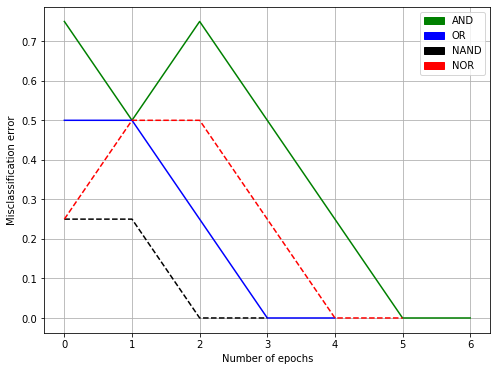

In [109]:
import matplotlib.patches as mpatches


g_patch = mpatches.Patch(color='green', label='AND')
b_patch = mpatches.Patch(color='blue', label='OR')
k_patch = mpatches.Patch(color='black', label='NAND')
r_patch = mpatches.Patch(color='red', label='NOR')

plt.figure(figsize=(8, 6))
plt.plot(range(7), and_cls_errors[:7], "-g")
plt.plot(range(5), or_cls_errors[:5], "-b")
plt.plot(range(4), nand_cls_errors[:4], "--k")
plt.plot(range(6), nor_cls_errors[:6], "--r")
plt.grid(True)
plt.ylabel("Misclassification error")
plt.xlabel("Number of epochs")
plt.legend(handles=[g_patch, b_patch, k_patch, r_patch])
plt.show()

## 1.3 XOR gate cannot be fit with linear predictor function (like the Perceptron)

[0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.  ]


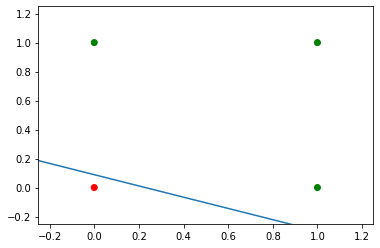

In [36]:
# Learning the decision boundary

case = dataset["or"]
X = np.array(case["X"])
y = np.array(case["y"])

# 1. concatenate bias vector shape (1, X.nrows) into X
coefs, cls_errors = perceptron.fit(perceptron.insert_intercept(X), y, max_epochs=15)  # including intercept @ idx 0
print(cls_errors)

x1 = np.linspace(-0.5, 1.5, 10)
x2 = perceptron.decision_function2d(x1, coefs)

perceptron.plot_graph(X, y, x1, x2)

### 1.2.2 Convergence

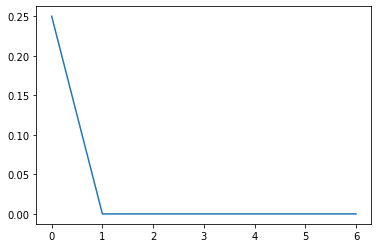

In [37]:
import matplotlib.pyplot as plt

plt.plot(range(7), cls_errors[:7])
plt.show()

## 1.1 Simplified alternative

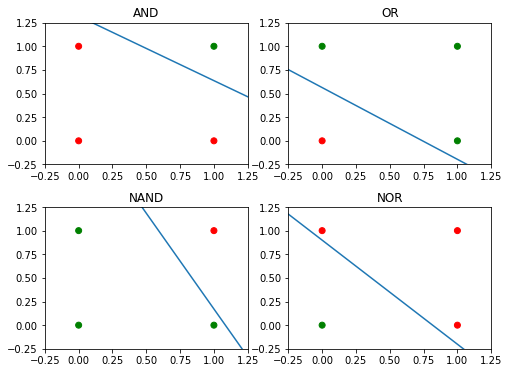

In [113]:
def get_colors(y):
    colors = [None, 'green', 'red']  # class 1: green, class -1: red
    return [colors[c] for c in y]


plt.figure(figsize=(8, 6))
X = np.array(dataset["and"]["X"])  # Coordinates are the same for all boolean logic gates
models = {}

for i, case in enumerate(["and", "or", "nand", "nor"]):
    y = dataset[case]["y"]
    coefs, cls_errors = perceptron.fit(
        perceptron.insert_intercept(X), 
        np.array(y), 
        max_epochs=15)

    models[case] = {"coefs": coefs, "cls_errors": cls_errors}
    xx = np.linspace(-0.5, 1.5, 10)
    yy = perceptron.decision_function2d(xx, coefs)

    plt.subplot(221+i)
    plt.xlim(-0.25, 1.25)
    plt.ylim(-0.25, 1.25)
    plt.scatter(X[:,0], X[:,1], c=get_colors(y))
    plt.plot(xx, yy)  # decision boundary
    plt.title(case.upper())


plt.subplots_adjust(hspace=0.30)
plt.show()

### 1.3.2 Convergence

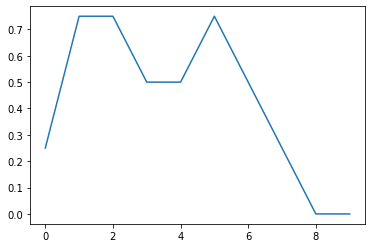

In [42]:
import matplotlib.pyplot as plt

plt.plot(range(10), cls_errors[:10])
plt.show()

## 1.1 XOR function

[0.5  0.75 0.5  0.75 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.  ]


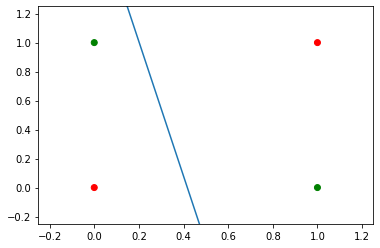

In [58]:
# Learning the decision boundary

case = dataset["xor"]
X = np.array(case["X"])
y = np.array(case["y"])

# 1. concatenate bias vector shape (1, X.nrows) into X
coefs, cls_errors = perceptron.fit(perceptron.insert_intercept(X), y, max_epochs=15)  # including intercept @ idx 0
print(cls_errors)

x1 = np.linspace(-0.5, 1.5, 10)
x2 = perceptron.decision_function2d(x1, coefs)

perceptron.plot_graph(X, y, x1, x2)

### 1.1.2 Convergence

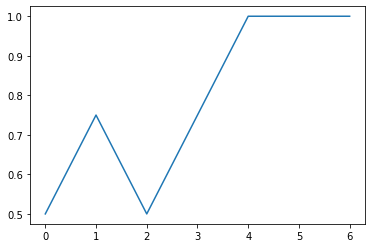

In [59]:
import matplotlib.pyplot as plt

plt.plot(range(7), cls_errors[:7])
plt.show()

# Part 2. MNIST

1. Load the first N = 5000 MNIST digits. Select only those digits in the training set which are either zeros or ones
2. Take the first N/2 digits to be training set, 
3. and the remaining N/2 to be the test set. 
4. Apply your implementation of the perceptron algorithm to this data. (Remember that the corresponding class vector has to be converted to ±1.) 
5. Does the algorithm converge? After how many iterations? 
6. Applying the learned linear classifier to the test set (using only those instances which are zeros or ones), what is the error rate? 
7. Plot the pixel weights as an image (leaving out the bias weight), does it resemble a zero or a one? Why or why not?

In [1]:
import numpy as np
from mnist import MNIST

mndata = MNIST('data')


# 1, 2, 3
images, labels = mndata.load_training()
images = np.array(images)[:5000]
labels = np.array(labels)[:5000]
mask = (labels == 0) + (labels == 1)
images = images[mask]
labels = labels[mask]
ls = []
for l in labels:
    if l == 0:
        ls.append(-1)
    else:
        ls.append(l)
labels = np.array(ls)
split_idx = int(len(labels)/2)
X_train, y_train = images[:split_idx], labels[:split_idx]
X_test, y_test = images[split_idx:], labels[split_idx:]

label: -1


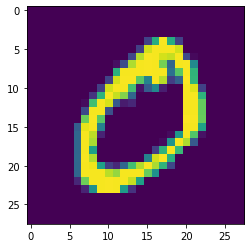

In [53]:
import matplotlib.pyplot as plt

imgidx = 0
print(f"label: {y_train[imgidx]}")
plt.imshow(X_train[imgidx].reshape(28, 28))

In [3]:
import perceptron

# 4, 5
coefs = perceptron.fit(X_train, y_train, max_epochs=50)

All correct! Epoch 5


In [24]:
preds = perceptron.predict(coefs, X_test)

In [28]:
def convert_labels(y, threshold=0):
    """
    Converts labels from real value domain to binary classes [-1, 1] based on threshold.
    """
    y_new = [1 if e >= 0 else -1 for e in y]
    return np.array(y_new)


def accuracy(y_true, y_pred):
    true_mask = (y_true == y_pred)
    return true_mask.sum() / true_mask.shape[0]


# 6
conv_preds = convert_labels(preds)
print(accuracy(y_test, conv_preds))

1.0


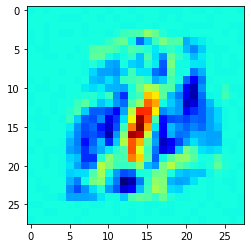

In [33]:
# 7
plt.imshow(coefs.reshape(28, 28), cmap='jet')

In [45]:
for i in range(392, 420):
    print(coefs[i])

0.3685637257994935
0.008820261959898157
0.24642588283835454
0.9564177361115116
0.20094646169326513
108.27646194870825
-128.13780182164328
-435.33758878451624
-492.78797443047756
-325.53753477448265
-805.418782942576
-562.1044090057316
-68.90279596028131
768.3343514835302
1712.3829576765486
1296.9426425622698
182.7279844367986
-667.3574500547427
-495.83495225014315
-459.5168206948502
-529.9706896721743
-415.7246014250303
-448.9618748255588
-252.25602422108477
-111.94280891263344
0.3173335426486299
0.7532137263046057
0.3395417091173507
